# Setup

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as tvu
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io

import sklearn.metrics as metrics

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import time
import os
import copy

## Device and Global Params

In [2]:
## Use GPU if available
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

print('number of gpus:', torch.cuda.device_count())

## Use float as default
# this works for both cpu (FloatTensor) and gpu (cuda.FloatTensor)
dtype = torch.float
torch.set_default_dtype(dtype)

## Image size to resize to
IMAGE_SIZE = 224

using device: cuda
number of gpus: 2


# Datasets and Loaders

## Datasets and Loaders for Models Using both Image and Pre-extracted Features  
To load image and pre-extracted features, first define a custom subclass of Dataset, then define transform functions, and Dataloaders.

### Define Dataset Class

In [3]:
#### PIL image loader to load images
def pil_loader(path):
    with open(path, 'rb') as f:
        image = Image.open(f)
        return image.convert('RGB')

#### Define TextImageDataset class to load text and image data
## This inherits the Dataset class in torch.utils.data
class TextImageDataset(Dataset):

    def __init__(self, csv_file, root_dir, loader, img_transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with text data.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample. Apply only to the image data.
        """
        self.features_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.loader = loader
        self.img_transform = img_transform
        # self.feature_transform = feature_transform

    def __len__(self):
        return len(self.features_frame)

    def __getitem__(self, idx):
        ## image_name: unique image identifier. Second column in text_data.
        ## label: no = 0, yes = 1. Fourth column in text_data
        ## features: all other features in the loaded csv
        image_name = self.features_frame.iloc[idx, 1]
        image_path = os.path.join(self.root_dir, image_name)
        #image = io.imread(image_name)
        image = self.loader(image_path)
        label = self.features_frame.iloc[idx, 3]
        features = self.features_frame.iloc[idx, 4:].values.astype(np.float)
        features = torch.from_numpy(features).float()
        
        if self.img_transform:
            image = self.img_transform(image)
        
        # if self.feature_transform:
        #    features = self.feature_transform(features)

        return image, features, label, image_path

### Dataset Instances

In [4]:
#### Transform Function for Images
## For the type of data, it is not useful to do any cropping or changing ratio.
image_transform = T.Compose([
    T.Resize(size = (IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor()
])

# #### Transform Function for Images
# feature_transform = T.Compose([
#     T.ToTensor()
# ])

trainset = TextImageDataset(csv_file = './data/tag_fact_train.csv', 
                            root_dir = './data/fact_tr',
                            loader = pil_loader,
                            img_transform = image_transform) 
                            # feature_transform = feature_transform)
valset = TextImageDataset(csv_file = './data/tag_fact_val.csv', 
                            root_dir = './data/fact_val', 
                            loader = pil_loader,
                            img_transform = image_transform)
                            # feature_transform = feature_transform)
dataset_sizes = {'train': len(trainset), 'val': len(valset)} # for train function

In [ ]:
#### Check Dataset integrity
test_frame = pd.read_csv('./data/tag_fact_val.csv')
image_path = os.path.join('./data/fact_val/',
                            test_frame.iloc[4, 1])
print(image_path)
image = pil_loader(image_path)
trsfm_img = image_transform(image)
img_np = trsfm_img.numpy()
plt.imshow(np.transpose(img_np, (1, 2, 0)))

In [ ]:
img_name = valset[4][3]
print(img_name)
img = valset[4][0].numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))

### Loaders

In [5]:
#### Loaders to load datasets in batch
loader_train = DataLoader(trainset, batch_size = 32, num_workers = 8, shuffle = True)
loader_val = DataLoader(valset, batch_size = 32, num_workers = 8, shuffle = True)
dataloaders = {'train' : loader_train, 'val' : loader_val} # for train function

(3, 224, 224) torch.Size([122]) 0 ./data/fact_tr/CHI02_img_CHI0220170406125320.jpg
(3, 224, 224) torch.Size([122]) 0 ./data/fact_tr/CHI06_img_Default chi10620170417070000.jpg
(3, 224, 224) torch.Size([122]) 0 ./data/fact_tr/CHI06_img_Default chi10620170417090010.jpg


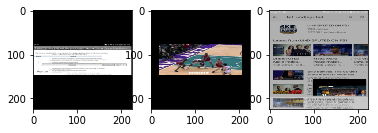

In [6]:
#### Check Loader integrity
images_so_far = 0
for i, (img, f, l, img_name) in enumerate(trainset):
    images_so_far += 1
    img_np = img.numpy()
    ax = plt.subplot(1, 3, images_so_far)
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    print(img_np.shape, f.shape, l, img_name)
    if i == 2:
        break

# Visualize Original Images

## Visualize a batch of original images

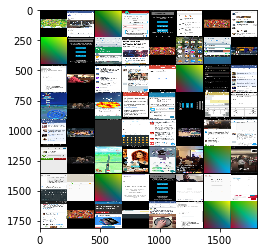

In [17]:
loader_train_show = DataLoader(trainset, batch_size = 64, num_workers = 8, shuffle = True)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(loader_train_show)
images, _, _, _ = dataiter.next()

# show images
imshow(tvu.make_grid(images, nrow = 8))
tvu.save_image(images, "train_grid.png")

## Visualize the average image of each class

In [9]:
# #### plot the average image
# train_N = train_Y = 0
# for _, _, label, _ in trainset:
#     if label == 0:
#         train_N += 1
#     else:
#         train_Y += 1
# print(train_N, train_Y) # (3444, 920)

loader_train_avg = DataLoader(trainset, batch_size = 1, shuffle = True)

train_N = 3444
train_Y = 920
# avg_no = avg_yes = torch.zeros(trainset[1][0].shape, dtype = dtype)
# for i, (img, feature, label, _) in enumerate(loader_train_avg): 
#         if label == 0:
#             avg_no = avg_no + img / train_N
#         else:
#             avg_yes = avg_yes + img / train_Y

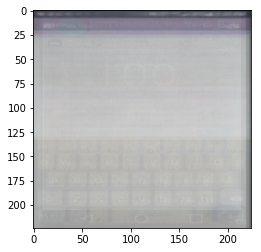

In [96]:
avg_yes_np = avg_yes.numpy().reshape(avg_yes.shape[1:])
plt.imshow(np.transpose(avg_yes_np, (1, 2, 0)))
tvu.save_image(avg_yes, "train_y.png")

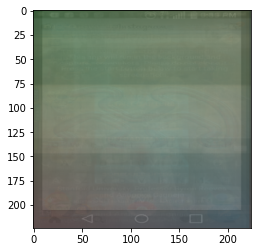

In [97]:
avg_no_np = avg_no.numpy().reshape(avg_no.shape[1:])
plt.imshow(np.transpose(avg_no_np, (1, 2, 0)))
tvu.save_image(avg_no, "train_n.png")

# Metrics and Train Functions

## Functions to check performance  
check_metrics is used to check test set performance. It prints accuracy, kappa, and confusion matrix as performance metrics.

In [7]:
def check_metrics(loader, model):
    if loader.dataset.val:
        print('Checking performance on validation set')
    else:
        print('Checking performance on test set')   
    num_correct = 0
    num_samples = 0
    y_true = torch.tensor([], dtype = torch.long) # to store all true labels
    y_pred = torch.tensor([], dtype = torch.long) # to store all preds
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device, dtype = dtype)
            y = y.to(device = device, dtype = torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            y_true = torch.cat((y_true, y))
            y_pred = torch.cat((y_pred, preds))
        acc = float(num_correct) / num_samples
        kappa = metrics.cohen_kappa_score(y_true.numpy(), y_pred.numpy())
        cfmatrix = metrics.confusion_matrix(y_true.numpy(), y_pred.numpy())
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('kappa = %.4f' % kappa)
        print(cfmatrix)

## Check-pointing functions

In [8]:
#### Check-pointing
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

## Training function

In [9]:
#### Training function
## Train model and print performance metrics for train and val sets.
## Returns the models with best accuracy and kappa.
## use_image: train with image.
## use_feature: train with pre-extracted features.
## if use_image and use_feature == True, train with both.
## use_ReduceLROnPlateau: use optim.lr_scheduler.ReduceLROnPlateau for training.
## max_kappa: set optim.lr_scheduler.ReduceLROnPlateau to maximize kappa
def train(model, criterion, optimizer, scheduler, 
          num_epochs = 5, use_image = True, use_feature = True, use_ReduceLROnPlateau = False, max_kappa = False):
    since = time.time()

    # set metrics placeholders
#     best_acc_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
#     best_kappa_model_wts = copy.deepcopy(model.state_dict())
    best_kappa = 0.0
    
    # dicts to save epoch metrics
    losses = {x : [] for x in ['train', 'val']}
    accuracies = {x : [] for x in ['train', 'val']}
    kappas = {x : [] for x in ['train', 'val']}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # if using scheduler other than ReduceLROnPlateau
                if not use_ReduceLROnPlateau:
                    scheduler.step() # not required for lr_scheduler.ReduceLROnPlateau
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            y_true = torch.tensor([]).long().to(device) # to store all true labels
            y_pred = torch.tensor([]).long().to(device) # to store all preds
            
            # Iterate over data.
            for images, features, labels, _ in dataloaders[phase]:
                images = images.to(device)
                # modify size of features to (N, C, L), where C is channel required for nn.Conv1d
                features = features.view(features.size(0), 1, features.size(1))
                features = features.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # generate outputs depending on model type
                    if use_image and not use_feature:
                        outputs = model(images)
                    elif not use_image and use_feature: 
                        outputs = model(features)
                    else:
                        outputs = model(images, features)
                        
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # store true and pred labels
                y_true = torch.cat((y_true, labels))
                y_pred = torch.cat((y_pred, preds))
            
            # compute and save metrics
            y_true = y_true.cpu()
            y_pred = y_pred.cpu()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_kappa = metrics.cohen_kappa_score(y_true.numpy(), y_pred.numpy())
            cfmatrix = metrics.confusion_matrix(y_true.numpy(), y_pred.numpy())
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            kappas[phase].append(epoch_kappa)

            print('{} Loss: {:.4f} Acc: {:.4f} kappa: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_kappa))
            print('Confusion Matrix: \n', cfmatrix)

            # use ReduceLROnPlateau if flag is true
            # save model if accuracy or kappa is the best
            if phase == 'val':
                if use_ReduceLROnPlateau:
                    if max_kappa:
                        scheduler.step(epoch_kappa)
                    else:
                        scheduler.step(epoch_loss) # step if loss of valset stagnates
                if use_image and not use_feature:
                    model_type = 'image' 
                elif not use_image and use_feature:
                    model_type = 'feature'
                else:
                    model_type = 'both'
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    # best_acc_model_wts = copy.deepcopy(model.state_dict())
                    save_checkpoint('best_acc_%s.pth' % model_type, model, optimizer)
                if epoch_kappa > best_kappa:
                    best_kappa = epoch_kappa
                    # best_kappa_model_wts = copy.deepcopy(model.state_dict())
                    save_checkpoint('best_kappa_%s.pth' % model_type, model, optimizer)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} kappa: {:4f}'.format(best_acc, best_kappa))

    # load best model weights
    # model instances depending on model type
#     if use_image and not use_feature:
#         model_best_acc = ImageCNN()
#         model_best_kappa = ImageCNN()
#     elif not use_image and use_feature:
#         model_best_acc = FeatureCNN()
#         model_best_kappa = FeatureCNN()
#     else:
#         model_best_acc = ImageAndFeatureCNN()
#         model_best_kappa = ImageAndFeatureCNN()

#     model_best_acc.load_state_dict(best_acc_model_wts)
#     model_best_kappa.load_state_dict(best_kappa_model_wts)
    
    # return model_best_acc, model_best_kappa
    
    return losses, accuracies, kappas

# CNN Architecture: Image and Pre-extracted Features  
This CNN architecture combines two CNNs with a multi-layer perceptron (MLP) network. One CNN classifies the images directly, and the other classifies the images using pre-extracted, mainly textual features. These two CNNs do not have final FC layers as classifiers. Rather, the final layers of the two CNNs are concatenated and fed into the MLP. The MLP generates the class scores and serves as the final classifier.

## Train with image only
Train using transfer learning: due to the fact that the data at hand is vastly different from ImageNet, this fine-tunes the model instead of using it simply as a feature extracter.

In [10]:
#### ImageCNN: CNN module for images
## This utilizes transfer learning. 
## Modify the last fc layer in the transferred model and to a fc layer that matches with the intended #classes.
class ImageCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.image_model = models.resnet18(pretrained = True)
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, 2) # add fc layer
        
    def forward(self, x):
        x = self.image_model(x)
        outputs = x
        return outputs

In [23]:
model_image = ImageCNN()
model_image = nn.DataParallel(model_image)
model_image = model_image.to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer_image = optim.SGD(model_image.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.01)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_image, step_size = 5, gamma = 0.1)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_image, patience = 5, factor = 0.1, verbose = True)

losses_model_image, accuracies_model_image, kappas_model_image = \
    train(model_image, criterion, optimizer_image, exp_lr_scheduler, 
          num_epochs = 30, use_image = True, use_feature = False, use_ReduceLROnPlateau = True)

Epoch 0/29
----------
train Loss: 0.3661 Acc: 0.8531 kappa: 0.5358
Confusion Matrix: 
 [[3185  259]
 [ 382  538]]
val Loss: 0.2575 Acc: 0.8891 kappa: 0.6698
Confusion Matrix: 
 [[798  43]
 [ 78 172]]
model saved to best_acc_image.pth
model saved to best_kappa_image.pth

Epoch 1/29
----------
train Loss: 0.2304 Acc: 0.9086 kappa: 0.7144
Confusion Matrix: 
 [[3292  152]
 [ 247  673]]
val Loss: 0.2402 Acc: 0.8928 kappa: 0.6826
Confusion Matrix: 
 [[798  43]
 [ 74 176]]
model saved to best_acc_image.pth
model saved to best_kappa_image.pth

Epoch 2/29
----------
train Loss: 0.2216 Acc: 0.9099 kappa: 0.7217
Confusion Matrix: 
 [[3282  162]
 [ 231  689]]
val Loss: 0.2514 Acc: 0.8873 kappa: 0.6958
Confusion Matrix: 
 [[762  79]
 [ 44 206]]
model saved to best_kappa_image.pth

Epoch 3/29
----------
train Loss: 0.1944 Acc: 0.9207 kappa: 0.7573
Confusion Matrix: 
 [[3294  150]
 [ 196  724]]
val Loss: 0.2391 Acc: 0.9038 kappa: 0.7201
Confusion Matrix: 
 [[798  43]
 [ 62 188]]
model saved to best_a

In [ ]:
#### Save image only model
# save_checkpoint('best_acc_image.pth', best_acc_image, optimizer_image) #  Todo: optimizer not having the right states
# save_checkpoint('best_kappa_image.pth', best_kappa_image, optimizer_image)

## Train with pre-extracted features only
Train using pre-extracted features with the FeatureCNN module defined above.

In [11]:
#### FeatureCNN: CNN  module for the 1-D pre-extracted features
## The pre-extracted features are loaded from a csv file.
## Each image has a corresponding set of features, which is of length = 122.
## These features are already normalized.
## remove_fc: flag if not including the last fc layer.
class FeatureCNN(nn.Module):
    def __init__(self, remove_fc = False):
        super().__init__()
        
        self.remove_fc = remove_fc
        
        self.Conv_BN_Relu_Pool_1 = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding = 1), # L = (122 + 2 - 3) / 1 + 1 = 122
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, padding = 1), # L' = (L + 2 - 3) / 1 + 1 = 122
            nn.ReLU(),
            nn.MaxPool1d(2, padding = 1), # C = 32, L'' = (L' + 2 - 2) / 2  + 1 = 62
            nn.BatchNorm1d(32)
        )

        self.Conv_BN_Relu_Pool_2 = nn.Sequential(
            nn.Conv1d(32, 64, 1, padding = 0), # L = (62 - 1) / 1 + 1 = 62
            nn.ReLU(),
            nn.Conv1d(64, 64, 1, padding = 0), # L' = (L - 1) / 1 + 1 = 62
            nn.ReLU(),
            nn.MaxPool1d(2, padding = 1), # C = 64, L'' = (L' + 2 - 2) / 2 + 1 = 32
            nn.BatchNorm1d(64)
        )
        
        # Compute image size after the conv and pool layers
        newH = ((122 + 2 - 3) / 1 + 1 + 2 - 2) / 2 + 1
        newH = ((((newH - 1) / 1 + 1) - 1) / 1 + 1 + 2 - 2) / 2 + 1
        
        self.Affine = nn.Sequential(
            nn.Linear(64 * newH, 1024),
            nn.BatchNorm1d(1024)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 2)
        )
    
    def forward(self, x):
        x = self.Conv_BN_Relu_Pool_1(x)
        x = self.Conv_BN_Relu_Pool_2(x)
        x = x.view(x.size(0), -1)
        x = self.Affine(x)
        if self.remove_fc:
            outputs = x
        else:
            x = self.fc(x)
            outputs = x
        return outputs

In [33]:
model_feature = FeatureCNN()
model_feature = nn.DataParallel(model_feature)
model_feature = model_feature.to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer_feature = optim.SGD(model_feature.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.01)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_feature, step_size = 5, gamma = 0.5)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_feature, patience = 5, factor = 0.1, verbose = True)

losses_model_feature, accuracies_model_feature, kappas_model_feature = \
    train(model_feature, criterion, optimizer_feature, exp_lr_scheduler, 
      num_epochs = 40, use_image = False, use_feature = True, use_ReduceLROnPlateau = True)

Epoch 0/39
----------
train Loss: 0.4677 Acc: 0.7874 kappa: 0.3797
Confusion Matrix: 
 [[2942  502]
 [ 426  494]]
val Loss: 0.3521 Acc: 0.8313 kappa: 0.5318
Confusion Matrix: 
 [[742  99]
 [ 85 165]]
model saved to best_acc_feature.pth
model saved to best_kappa_feature.pth

Epoch 1/39
----------
train Loss: 0.3506 Acc: 0.8325 kappa: 0.4737
Confusion Matrix: 
 [[3133  311]
 [ 420  500]]
val Loss: 0.3221 Acc: 0.8552 kappa: 0.5901
Confusion Matrix: 
 [[762  79]
 [ 79 171]]
model saved to best_acc_feature.pth
model saved to best_kappa_feature.pth

Epoch 2/39
----------
train Loss: 0.3243 Acc: 0.8495 kappa: 0.5186
Confusion Matrix: 
 [[3191  253]
 [ 404  516]]
val Loss: 0.3196 Acc: 0.8616 kappa: 0.5493
Confusion Matrix: 
 [[812  29]
 [122 128]]
model saved to best_acc_feature.pth

Epoch 3/39
----------
train Loss: 0.3070 Acc: 0.8579 kappa: 0.5478
Confusion Matrix: 
 [[3204  240]
 [ 380  540]]
val Loss: 0.3049 Acc: 0.8488 kappa: 0.5639
Confusion Matrix: 
 [[765  76]
 [ 89 161]]

Epoch 4/39
-

In [ ]:
#### Save features-only model
# save_checkpoint('best_acc_feature.pth', best_acc_feature, optimizer_feature) #  Todo: optimizer not having the right states
# save_checkpoint('best_kappa_feature.pth', best_kappa_feature, optimizer_feature)

## Train with both image and pre-extracted features

In [12]:
#### ImageAndFeatureCNN: CNN module that takes both image and pre-extracted features inputs
## This module combines two CNN modules and a MLP module.
## The ImageCNN module utilizes transfer learning. 
## Given the very different dataset, the transferred model is fine-tuned.
## The FeatureCNN module is a CNN on 1-d pre-extracted features.
## The MLP module takes the concatenated features from ImageCNN and FeatureCNN and outputs a classifier.

class ImageAndFeatureCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        image_module = ImageCNN() # this is a module containing the model for transfer learning
        image_model = list(image_module.children())[0] # 0th element is the transferred learning model
        self.image_model = nn.Sequential(*list(image_model.children())[:-1]) # remove the last fc layer
        
        self.feature_model = FeatureCNN(remove_fc = True)
        # somehow removing the fc layer using the following won't work.
#         feature_module = FeatureCNN() # this is a module containing the model for feature
#         self.feature_model = nn.Sequential(*list(feature_module.children())[:-1]) # remove the last fc layer
#         self.feature_model.fc = nn.Linear(1024, 1024)
        
        self.Conv_BN_Relu_Pool_1 = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding = 1), # L = (1536 + 2 - 3) / 1 + 1 = 1536
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, padding = 1), # L' = (L + 2 - 3) / 1 + 1 = 1536
            nn.ReLU(),
            nn.MaxPool1d(2), # C = 32, L'' = (L' - 2) / 2  + 1 = 768
            nn.BatchNorm1d(32)
        )

        self.Conv_BN_Relu_Pool_2 = nn.Sequential(
            nn.Conv1d(32, 64, 1, padding = 0), # L = (62 - 1) / 1 + 1 = 768
            nn.ReLU(),
            nn.Conv1d(64, 64, 1, padding = 0), # L' = (L - 1) / 1 + 1 = 768
            nn.ReLU(),
            nn.MaxPool1d(2), # C = 64, L'' = (L' - 2) / 2 + 1 = 384
            nn.BatchNorm1d(64)
        )
        
        # Compute image size after the conv and pool layers
        newH = ((1536 + 2 - 3) / 1 + 1 - 2) / 2 + 1
        newH = ((((newH - 1) / 1 + 1) - 1) / 1 + 1 - 2) / 2 + 1
        
        self.Affine = nn.Sequential(
            nn.Linear(64 * newH, 1024),
            nn.BatchNorm1d(1024)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 2)
        )
        
        
#         self.MLP = nn.Sequential(
#             nn.Linear(512 + 1024, 512), # number of input features = sum of number of nodes in image and feature models
#             nn.BatchNorm1d(512),
#             nn.Linear(512, 128),
#             nn.BatchNorm1d(128),
#             nn.Linear(128, 2)
#         )
        
    def forward(self, x1, x2):
        x1 = self.image_model(x1)
        x1 = x1.view(x1.size(0), x1.size(1)) # reshape from (N, C, 1, 1) to (N, C)
        x2 = self.feature_model(x2)
        x = torch.cat((x1, x2), 1)
        x = x.view(x.size(0), 1, x.size(1))
        x = self.Conv_BN_Relu_Pool_1(x)
        x = self.Conv_BN_Relu_Pool_2(x)
        x = x.view(x.size(0), -1)
        x = self.Affine(x)
        x = self.fc(x)
#         x = self.MLP(x)
        outputs = x
        return outputs

In [49]:
model0 = ImageAndFeatureCNN()
model0 = nn.DataParallel(model0)
model0 = model0.to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer0 = optim.SGD(model0.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.01)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer0, patience = 5, factor = 0.1, verbose = True)


losses_model0, accuracies_model0, kappas_model0 = \
    train(model0, criterion, optimizer0, exp_lr_scheduler, 
      num_epochs = 30, use_image = True, use_feature = True, use_ReduceLROnPlateau = True)

Epoch 0/29
----------
train Loss: 0.4169 Acc: 0.8194 kappa: 0.4825
Confusion Matrix: 
 [[2989  455]
 [ 333  587]]
val Loss: 0.3810 Acc: 0.8231 kappa: 0.5720
Confusion Matrix: 
 [[684 157]
 [ 36 214]]
model saved to best_acc_both.pth
model saved to best_kappa_both.pth

Epoch 1/29
----------
train Loss: 0.2514 Acc: 0.8992 kappa: 0.6878
Confusion Matrix: 
 [[3261  183]
 [ 257  663]]
val Loss: 0.2527 Acc: 0.8845 kappa: 0.6636
Confusion Matrix: 
 [[788  53]
 [ 73 177]]
model saved to best_acc_both.pth
model saved to best_kappa_both.pth

Epoch 2/29
----------
train Loss: 0.2182 Acc: 0.9120 kappa: 0.7284
Confusion Matrix: 
 [[3285  159]
 [ 225  695]]
val Loss: 0.2583 Acc: 0.8946 kappa: 0.6908
Confusion Matrix: 
 [[796  45]
 [ 70 180]]
model saved to best_acc_both.pth
model saved to best_kappa_both.pth

Epoch 3/29
----------
train Loss: 0.1950 Acc: 0.9283 kappa: 0.7812
Confusion Matrix: 
 [[3306  138]
 [ 175  745]]
val Loss: 0.2754 Acc: 0.8937 kappa: 0.7173
Confusion Matrix: 
 [[760  81]
 [ 35

In [ ]:
#### Save model
# save_checkpoint('best_acc.pth', best_acc, optimizer) #  Todo: optimizer not having the right states
# save_checkpoint('best_kappa.pth', best_kappa, optimizer)

## Train with pre-trained image and pre-extracted features models

In [13]:
#### ImageAndFeatureCNNPreTrained: CNN module that utilizes pre-trained image-only and feature-only models
## This module takes the best performing image-only and feature-only models and removes last layers of the models.
## The loaded models work as feature extractors. 
## The features extracted from the two models are concatenated to produce a feature tensor.
## This feature tensor is fed into a MLP to produce a final classifier.
class ImageAndFeatureCNNPreTrained(nn.Module):
    def __init__(self, image_model, feature_model):
        super().__init__()
        
        # use pre-trained models as extractors
        self.image_model = image_model
        self.feature_model = feature_model
        
        self.Conv_BN_Relu_Pool_1 = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding = 1), # L = (1536 + 2 - 3) / 1 + 1 = 1536
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, padding = 1), # L' = (L + 2 - 3) / 1 + 1 = 1536
            nn.ReLU(),
            nn.MaxPool1d(2), # C = 32, L'' = (L' - 2) / 2  + 1 = 768
            nn.BatchNorm1d(32)
        )

        self.Conv_BN_Relu_Pool_2 = nn.Sequential(
            nn.Conv1d(32, 64, 1, padding = 0), # L = (62 - 1) / 1 + 1 = 768
            nn.ReLU(),
            nn.Conv1d(64, 64, 1, padding = 0), # L' = (L - 1) / 1 + 1 = 768
            nn.ReLU(),
            nn.MaxPool1d(2), # C = 64, L'' = (L' - 2) / 2 + 1 = 384
            nn.BatchNorm1d(64)
        )
        
        # Compute image size after the conv and pool layers
        newH = ((1536 + 2 - 3) / 1 + 1 - 2) / 2 + 1
        newH = ((((newH - 1) / 1 + 1) - 1) / 1 + 1 - 2) / 2 + 1
        
        self.Affine = nn.Sequential(
            nn.Linear(64 * newH, 1024),
            nn.BatchNorm1d(1024)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 2)
        )

#         self.MLP = nn.Sequential(
#             nn.Linear(512 + 1024, 512), # number of input features = sum of number of nodes in image and feature models
#             nn.ReLU(),
#             nn.BatchNorm1d(512),
#             nn.Linear(512, 2),
# #             nn.ReLU(),
# #             nn.BatchNorm1d(256),
# #             nn.Linear(256, 2)
#         )
        
    def forward(self, x1, x2):
        x1 = self.image_model(x1)
        x1 = x1.view(x1.size(0), x1.size(1)) # reshape from (N, C, 1, 1) to (N, C)
        x2 = self.feature_model(x2)
        x = torch.cat((x1, x2), 1)
        x = x.view(x.size(0), 1, x.size(1))
        x = self.Conv_BN_Relu_Pool_1(x)
        x = self.Conv_BN_Relu_Pool_2(x)
        x = x.view(x.size(0), -1)
        x = self.Affine(x)
        x = self.fc(x)
#         x = self.MLP(x)
        outputs = x
        return outputs

In [55]:
#### Load best-performing image-only models
image_module = ImageCNN() # this is a module containing the model for transfer learning
image_module = nn.DataParallel(image_module)
optimizer_image = optim.SGD(image_module.parameters(), lr = 0.01, momentum = 0.9)
load_checkpoint('best_kappa_image.pth', image_module, optimizer_image)
image_model = list(list(image_module.children())[0].children())[0] # 0th element is the transferred learning model
image_model = nn.Sequential(*list(image_model.children())[:-1]) # remove the last fc layer
for param in image_model.parameters(): # freeze all parameters
    param.requires_grad = False
image_model = image_model.to(device)
#### Load best-performing feature-only models
feature_model = FeatureCNN(remove_fc = True)
feature_model = nn.DataParallel(feature_model)
optimizer_feature = optim.SGD(feature_model.parameters(), lr = 0.01, momentum = 0.9)
load_checkpoint('best_kappa_feature.pth', feature_model, optimizer_feature) # load_state_dict does not need to match exactly
for param in feature_model.parameters(): # freeze all parameters
    param.requires_grad = False
feature_model = feature_model.to(device)

model = ImageAndFeatureCNNPreTrained(image_model, feature_model)
model = model.to(device = device)
criterion = nn.CrossEntropyLoss()
parameters = filter(lambda p: p.requires_grad, model.parameters()) # filter out the parameters that do not need to be optimized
optimizer = optim.SGD(parameters, lr = 0.01, momentum = 0.9, weight_decay = 0.1)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, factor = 0.1, verbose = True)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

losses_model, accuracies_model, kappas_model = \
    train(model, criterion, optimizer, exp_lr_scheduler, 
          num_epochs = 30, use_image = True, use_feature = True, use_ReduceLROnPlateau = True)

model loaded from best_kappa_image.pth
model loaded from best_kappa_feature.pth
Epoch 0/29
----------
train Loss: 0.0477 Acc: 0.9883 kappa: 0.9649
Confusion Matrix: 
 [[3417   27]
 [  24  896]]
val Loss: 0.2485 Acc: 0.9184 kappa: 0.7542
Confusion Matrix: 
 [[818  23]
 [ 66 184]]
model saved to best_acc_both.pth
model saved to best_kappa_both.pth

Epoch 1/29
----------
train Loss: 0.0772 Acc: 0.9927 kappa: 0.9778
Confusion Matrix: 
 [[3435    9]
 [  23  897]]
val Loss: 0.2763 Acc: 0.9028 kappa: 0.6892
Confusion Matrix: 
 [[829  12]
 [ 94 156]]

Epoch 2/29
----------
train Loss: 0.1015 Acc: 0.9931 kappa: 0.9792
Confusion Matrix: 
 [[3437    7]
 [  23  897]]
val Loss: 0.3224 Acc: 0.9129 kappa: 0.7518
Confusion Matrix: 
 [[796  45]
 [ 50 200]]

Epoch 3/29
----------
train Loss: 0.1001 Acc: 0.9922 kappa: 0.9764
Confusion Matrix: 
 [[3435    9]
 [  25  895]]
val Loss: 0.3072 Acc: 0.9166 kappa: 0.7480
Confusion Matrix: 
 [[818  23]
 [ 68 182]]

Epoch 4/29
----------
train Loss: 0.1024 Acc: 0.

# Visualization

## Visualization Function

In [15]:
#### Visualize Images Predicted by Models
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (80, 20))

    with torch.no_grad():
        for i, (images, features, labels, _) in enumerate(dataloaders['val']):
            images = images.to(device)
            features = features.view(features.size(0), 1, features.size(1))
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(images, features)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images // 2, images_so_far)
                ax.axis('off')
                ax.set_title('{}'.format(class_names[preds[j]]), size = 48)
                imshow(images.cpu().data[j])

                if images_so_far == num_images:
                    plt.savefig("predicted_images.png")
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

## Visualize Training 

### Visualize the training process for the image-only model

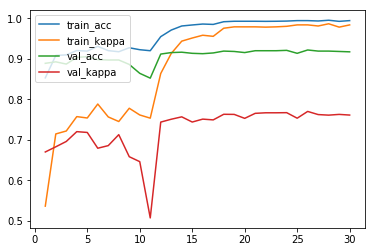

In [24]:
#### Plot acc and kappa
for phase in ['train', 'val']:
    e = np.arange(1, 31)
    plt.plot(e, accuracies_model_image[phase], label = '%s_acc' % phase)
    plt.plot(e, kappas_model_image[phase], label = '%s_kappa' % phase)
    plt.legend(loc = 2)
    plt.savefig("model_image_metrics_%s.png" % phase)

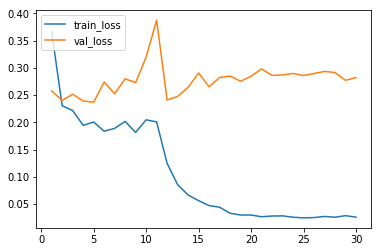

In [26]:
#### Plot loss
e = np.arange(1, 31)
plt.plot(e, losses_model_image['train'], label = '%s_loss' % 'train')
plt.plot(e, losses_model_image['val'], label = '%s_loss' % 'val')
plt.legend(loc = 2)
plt.savefig("model_image_loss.png")

### Visualize the training process for the feature-only model

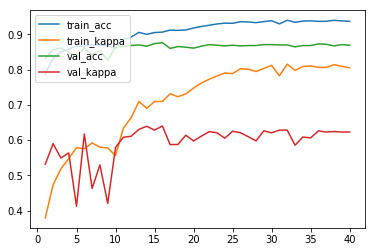

In [34]:
#### Plot acc and kappa
for phase in ['train', 'val']:
    e = np.arange(1, 41)
    plt.plot(e, accuracies_model_feature[phase], label = '%s_acc' % phase)
    plt.plot(e, kappas_model_feature[phase], label = '%s_kappa' % phase)
    plt.legend(loc = 2)
    plt.savefig("model_feature_metrics_%s.png" % phase)

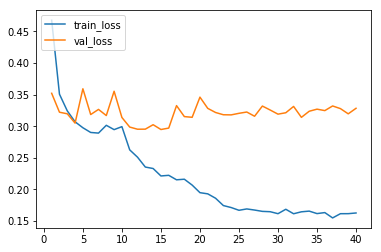

In [35]:
#### Plot loss
e = np.arange(1, 41)
plt.plot(e, losses_model_feature['train'], label = '%s_loss' % 'train')
plt.plot(e, losses_model_feature['val'], label = '%s_loss' % 'val')
plt.legend(loc = 2)
plt.savefig("model_feature_loss.png")

### Visualize the training process for the ImageAndFeatureCNN model

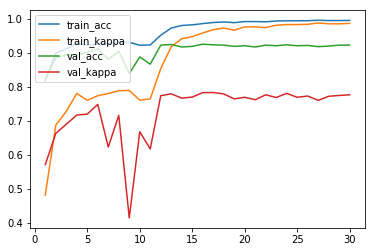

In [50]:
#### Plot acc and kappa
for phase in ['train', 'val']:
    e = np.arange(1, 31)
    plt.plot(e, accuracies_model0[phase], label = '%s_acc' % phase)
    plt.plot(e, kappas_model0[phase], label = '%s_kappa' % phase)
    plt.legend(loc = 2)
    plt.savefig("model0_metrics_%s.png" % phase)

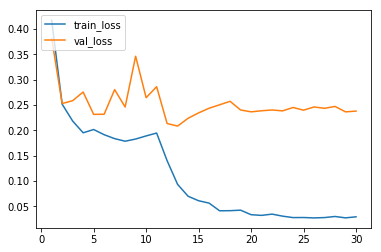

In [51]:
#### Plot loss
e = np.arange(1, 31)
plt.plot(e, losses_model0['train'], label = '%s_loss' % 'train')
plt.plot(e, losses_model0['val'], label = '%s_loss' % 'val')
plt.legend(loc = 2)
plt.savefig("model0_loss.png")

### Visualize the training process for the ImageAndFeatureCNNPreTrained model

In [ ]:
#### Plot acc and kappa
for phase in ['train', 'val']:
    e = np.arange(1, 31)
    plt.plot(e, accuracies_model[phase], label = '%s_acc' % phase)
    plt.plot(e, kappas_model[phase], label = '%s_kappa' % phase)
    plt.legend(loc = 2)
    plt.savefig("model_metrics_%s.png" % phase)

In [ ]:
#### Plot loss
e = np.arange(1, 31)
plt.plot(e, losses_model['train'], label = '%s_loss' % 'train')
plt.plot(e, losses_model['val'], label = '%s_loss' % 'val')
plt.legend(loc = 2)
plt.savefig("model_loss.png")

## Model Predictions
Predict whether screenshots would be considered factual or not.

model loaded from best_kappa_both.pth


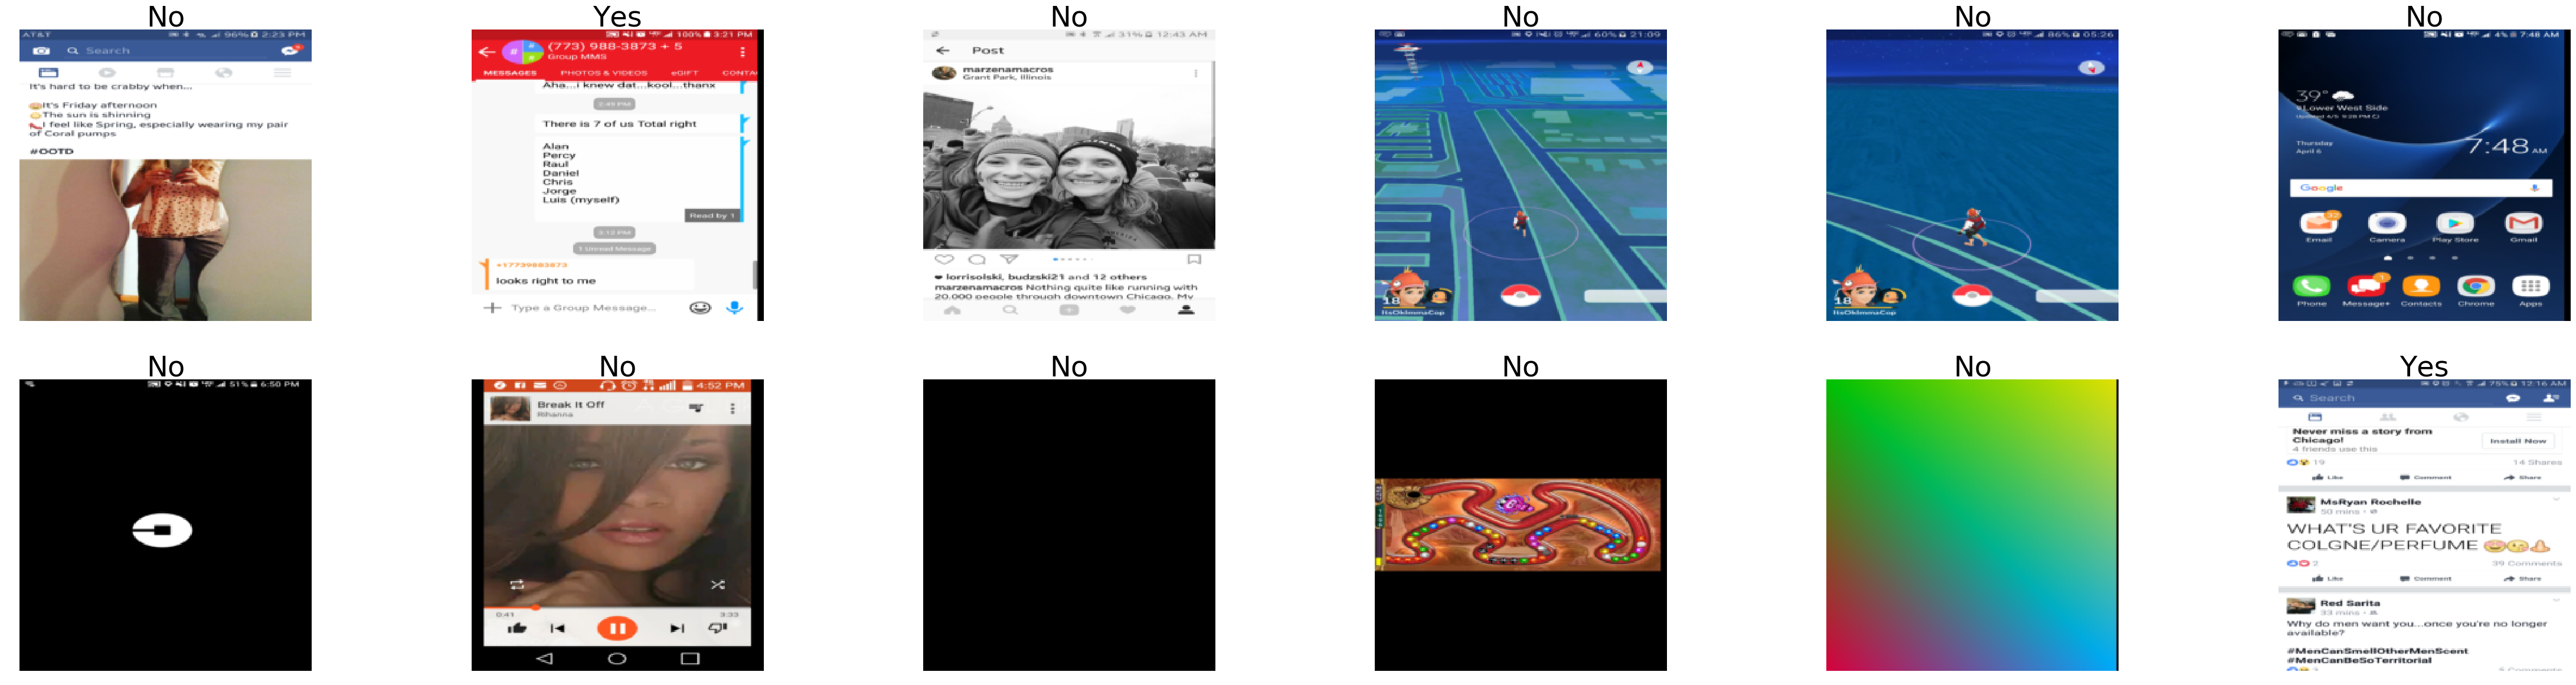

In [18]:
# class_names = trainset.classes
class_names = ['No', 'Yes']

image_module = ImageCNN() # this is a module containing the model for transfer learning
image_module = nn.DataParallel(image_module)
image_model = list(list(image_module.children())[0].children())[0] # 0th element is the transferred learning model
image_model = nn.Sequential(*list(image_model.children())[:-1]) # remove the last fc layer
for param in image_model.parameters(): # freeze all parameters
    param.requires_grad = False
image_model = image_model.to(device)

feature_model = FeatureCNN(remove_fc = True)
feature_model = nn.DataParallel(feature_model)
for param in feature_model.parameters(): # freeze all parameters
    param.requires_grad = False
feature_model = feature_model.to(device)

best_kappa_both = ImageAndFeatureCNNPreTrained(image_model, feature_model)
parameters = filter(lambda p: p.requires_grad, best_kappa_both.parameters()) 
optimizer = optim.SGD(parameters, lr = 0.01, momentum = 0.9)
load_checkpoint('best_kappa_both.pth', best_kappa_both, optimizer)
best_kappa_both = best_kappa_both.to(device)

visualize_model(best_kappa_both, 12)